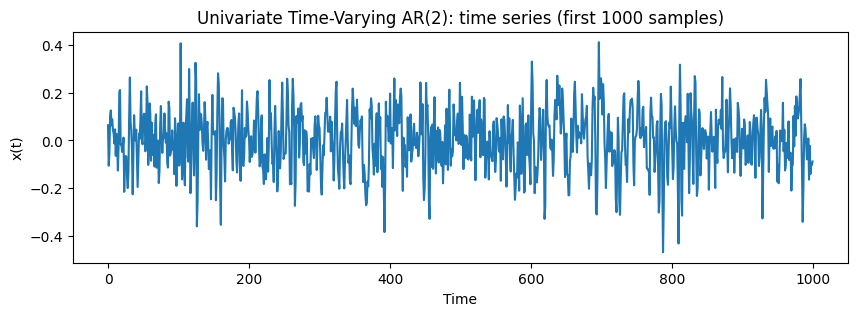

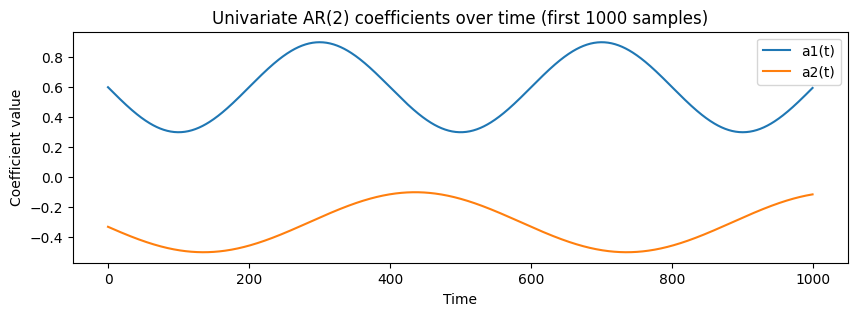

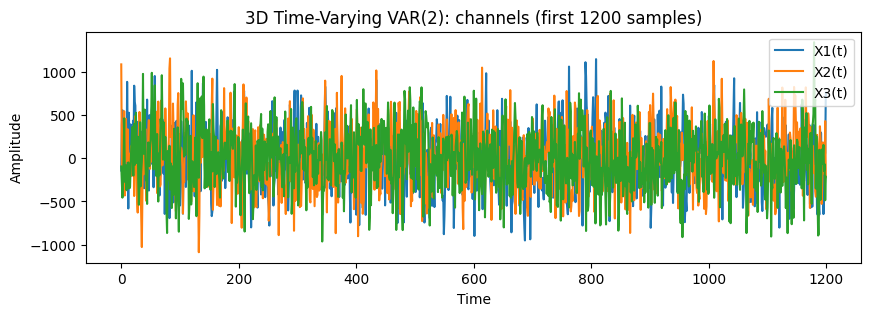

Simulation complete: stable univariate TV-AR(2) and 3D TV-VAR(2) generated.


In [1]:
# Fix multivariate simulation: use true 3D rotation matrices (orthogonal) to keep stability.
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(11)

def Rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0.0],
                     [s,  c, 0.0],
                     [0.0, 0.0, 1.0]])

def Ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0.0,  s],
                     [0.0, 1.0, 0.0],
                     [-s, 0.0,  c]])

def simulate_tvvar3_stable(T=4000, burn_in=300, noise_cov=None):
    """
    3D time-varying VAR(2) with smoothly rotating coupling matrices.
    Ensures stability by keeping eigenvalues small (spectral radius < 1).
    """
    if noise_cov is None:
        noise_cov =100000 * np.eye(3)
    L = np.linalg.cholesky(noise_cov)

    # stable diagonal eigenvalues for A1, A2
    alpha = np.array([0.45, 0.35, 0.30])  # first-lag magnitudes
    beta  = np.array([-0.10, -0.08, -0.06])  # second-lag magnitudes (negative helps damping)

    def angles(k):
        th1 = 2*np.pi * k / 500.0
        th2 = 2*np.pi * k / 900.0 + 0.7
        return th1, th2

    T_total = T + burn_in
    X = np.zeros((T_total, 3))
    eps = rng.normal(size=(T_total, 3)) @ L.T

    for k in range(2, T_total):
        th1, th2 = angles(k)
        R1 = Rz(th1) @ Ry(th1 * 0.5)
        R2 = Ry(th2) @ Rz(th2 * 0.5)

        A1 = R1 @ np.diag(alpha) @ R1.T  # orthogonally similar -> eigenvals are alpha
        A2 = R2 @ np.diag(beta)  @ R2.T  # eigenvals are beta

        X[k] = A1 @ X[k-1] + A2 @ X[k-2] + eps[k]

    return X[burn_in:], alpha, beta

# Re-run univariate from previous cell to keep together for the user
def simulate_tvar_univariate(T=3000, 
                             a1_base=0.6, a1_amp=0.3, a1_period=400, a1_phase=0.0,
                             a2_base=-0.3, a2_amp=0.2, a2_period=600, a2_phase=1.2,
                             noise_std=0.1, burn_in=200):
    T_total = T + burn_in
    t = np.arange(T_total)

    a1 = a1_base + a1_amp * np.sin(2*np.pi * t / a1_period + a1_phase)
    a2 = a2_base + a2_amp * np.sin(2*np.pi * t / a2_period + a2_phase)

    x = np.zeros(T_total)
    eps = rng.normal(0.0, noise_std, size=T_total)

    for k in range(2, T_total):
        x[k] = a1[k] * x[k-1] + a2[k] * x[k-2] + eps[k]

    return x[burn_in:], a1[burn_in:], a2[burn_in:]

# Run stable simulations
x_uni, a1_tv, a2_tv = simulate_tvar_univariate(T=4000)
X3, alpha_base, beta_base = simulate_tvvar3_stable(T=4000)

# Plot: Univariate TV-AR(2) (first 1000 samples)
plt.figure(figsize=(10, 3))
plt.plot(x_uni[:1000])
plt.title("Univariate Time-Varying AR(2): time series (first 1000 samples)")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.show()

# Plot: Coefficients over time (first 1000 samples)
plt.figure(figsize=(10, 3))
plt.plot(a1_tv[:1000], label="a1(t)")
plt.plot(a2_tv[:1000], label="a2(t)")
plt.title("Univariate AR(2) coefficients over time (first 1000 samples)")
plt.xlabel("Time")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()

# Plot: 3D TV-VAR(2) channels (first 1200 samples)
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.plot(X3[:1200, i], label=f"X{i+1}(t)")
plt.title("3D Time-Varying VAR(2): channels (first 1200 samples)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

print("Simulation complete: stable univariate TV-AR(2) and 3D TV-VAR(2) generated.")


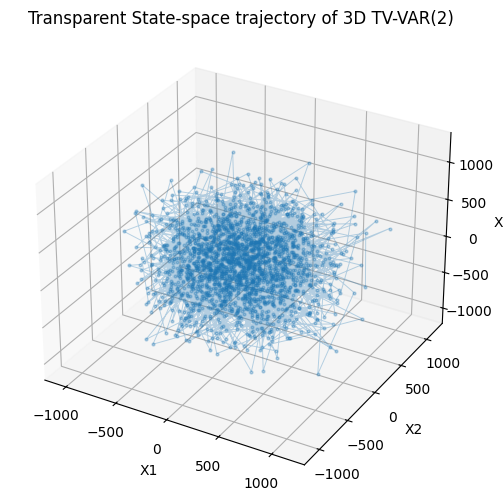

In [2]:
# Plot with both markers and connecting line partially transparent (alpha < 1.0).

window = slice(0, 2500)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot as line with small transparent markers
ax.plot(
    X3[window,0], X3[window,1], X3[window,2],
    marker='o', markersize=2, linewidth=0.7,
    alpha=0.3  # apply transparency to both line and markers
)

ax.set_title("Transparent State-space trajectory of 3D TV-VAR(2)")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()


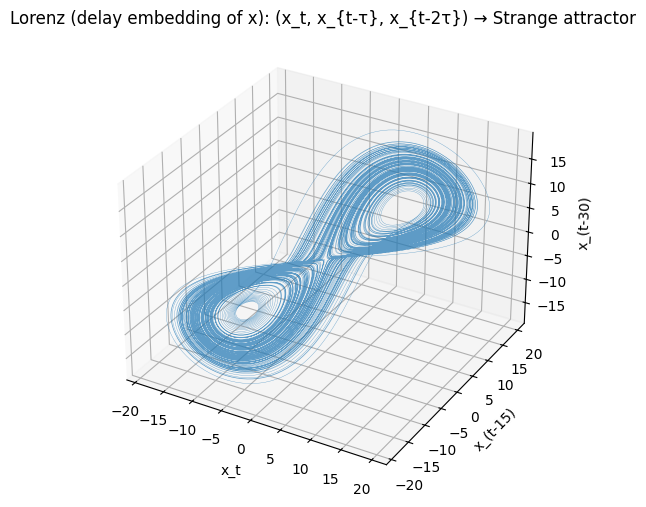

In [3]:
# Fix the slice arithmetic for the Lorenz delay embedding.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*0.005*k1[0], y + 0.5*0.005*k1[1], z + 0.5*0.005*k1[2])
        k3 = f(x + 0.5*0.005*k2[0], y + 0.5*0.005*k2[1], z + 0.5*0.005*k2[2])
        k4 = f(x + 0.005*k3[0], y + 0.005*k3[1], z + 0.005*k3[2])
        x += (0.005/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (0.005/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (0.005/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

tau = 15
start = 2 * tau
X1 = xs[start:]
X2 = xs[start - tau:-tau]
X3 = xs[start - 2*tau:-2*tau]

fig2 = plt.figure(figsize=(7,6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(X1, X2, X3, linewidth=0.25, alpha=0.7)
ax2.set_title("Lorenz (delay embedding of x): (x_t, x_{t-τ}, x_{t-2τ}) → Strange attractor")
ax2.set_xlabel("x_t")
ax2.set_ylabel(f"x_(t-{tau})")
ax2.set_zlabel(f"x_(t-{2*tau})")
plt.show()


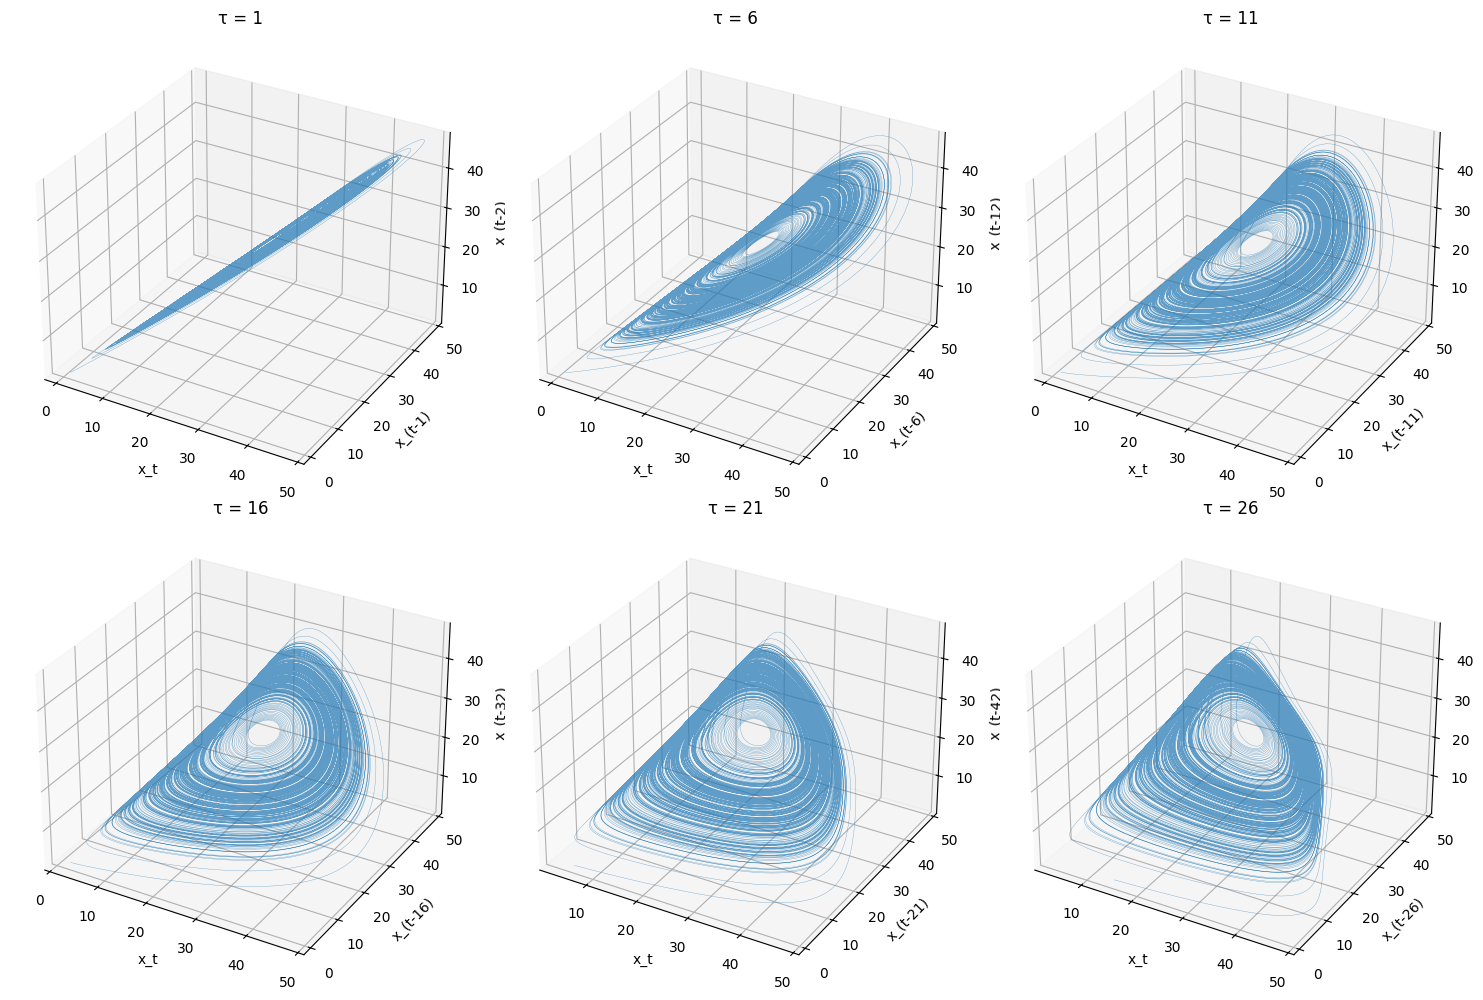

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

# Generate Lorenz data
xs, ys, zs = lorenz()

# Tau values from 1 to 30 in steps of 5
taus = list(range(1, 31, 5))

fig = plt.figure(figsize=(15, 10))

for i, tau in enumerate(taus, 1):
    start = 2 * tau
    X1 = zs[start:]
    X2 = zs[start - tau:-tau]
    X3 = zs[start - 2*tau:-2*tau]
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.plot(X1, X2, X3, linewidth=0.25, alpha=0.7)
    ax.set_title(f"τ = {tau}")
    ax.set_xlabel("x_t")
    ax.set_ylabel(f"x_(t-{tau})")
    ax.set_zlabel(f"x_(t-{2*tau})")

plt.tight_layout()
plt.show()


Effective window size : 20.480 (s)


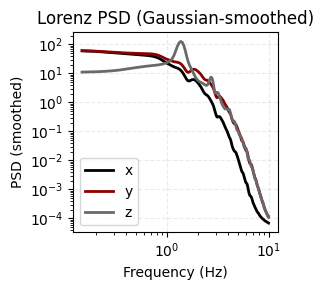

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# --- Lorenz simulator ---
def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = np.empty(T_steps), np.empty(T_steps), np.empty(T_steps)
    for i in range(T_steps):
        dx = sigma*(y-x); dy = x*(rho-z) - y; dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        xs[i], ys[i], zs[i] = x, y, z
    return xs, ys, zs, dt

# --- simulate ---
xs, ys, zs, dt = lorenz()
fs = 1.0/dt
burn = 2000  # drop transient
data = np.vstack([xs[burn:], ys[burn:], zs[burn:]])  # shape = (3, n_times)

# --- compute PSD for all three channels ---
psds, freqs = mne.time_frequency.psd_array_welch(
    data,
    sfreq=fs,
    fmin=0.1, fmax=10,
    n_fft=4096,
    n_overlap=2048,
    average='mean'
)

# # --- plot all channels ---
# plt.figure(figsize=(3,3))
# plt.loglog(freqs, psds[0], label='x', color='k', lw=1.6)
# plt.loglog(freqs, psds[1], label='y', color='darkred', lw=1.3)
# plt.loglog(freqs, psds[2], label='z', color='dimgray', lw=1.3)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("PSD (a.u./Hz)")
# plt.title("Lorenz PSD via MNE (Welch)")
# plt.grid(True, ls="--", alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()
# # 

from scipy.ndimage import gaussian_filter1d

# smooth each PSD along frequency axis
Pxx_smooth = gaussian_filter1d(psds[0], sigma=2)
Pyy_smooth = gaussian_filter1d(psds[1], sigma=2)
Pzz_smooth = gaussian_filter1d(psds[2], sigma=2)

plt.figure(figsize=(3,3))
plt.loglog(freqs, Pxx_smooth, 'k', lw=2, label="x")
plt.loglog(freqs, Pyy_smooth, 'darkred', lw=2, label="y")
plt.loglog(freqs, Pzz_smooth, 'dimgray', lw=2, label="z")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (smoothed)")
plt.title("Lorenz PSD (Gaussian-smoothed)")
plt.grid(True, ls="--", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import sys; print(sys.executable)
import mne; print(mne.__version__)


/usr/local/bin/python3
1.10.1


In [7]:
# least square vs p (elbow point)

In [8]:
# -*- coding: utf-8 -*-
"""
Make two publication-style mosaics (PNG):
  1) Torus (from a quasiperiodic time series lag embedding)
  2) Lorenz (delay embedding of x(t))
Layout: big 3D panel on the left, 3 small 2D projections stacked on the right.

Dependencies: numpy, matplotlib, pillow
"""

import os
from pathlib import Path
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed by mpl)


# ---------- Utilities ----------

def fig_to_image(fig, dpi=250) -> Image.Image:
    """Render a Matplotlib figure to a PIL Image (in memory; no temp files)."""
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGB")


def compose_mosaic(main_img: Image.Image,
                   side_imgs: list[Image.Image],
                   out_path: Path,
                   big_size=(1600, 1200),
                   small_size=(650, 400),
                   bg=(255, 255, 255)) -> Path:
    """
    Compose a mosaic: big image on the left; 3 side images stacked right.
    Returns the path where the final PNG is saved.
    """
    big_w, big_h = big_size
    small_w, small_h = small_size
    canvas_w, canvas_h = big_w + small_w, big_h

    # Resize panels with high-quality resampling
    try:
        Resample = Image.Resampling.LANCZOS
    except AttributeError:
        Resample = Image.LANCZOS

    main_resized = main_img.resize((big_w, big_h), Resample)
    side_resized = [im.resize((small_w, small_h), Resample) for im in side_imgs]

    canvas = Image.new("RGB", (canvas_w, canvas_h), bg)
    canvas.paste(main_resized, (0, 0))
    for i, im in enumerate(side_resized[:3]):
        canvas.paste(im, (big_w, i * small_h))

    out_path.parent.mkdir(parents=True, exist_ok=True)
    canvas.save(out_path)
    return out_path


def proj_2d_panel(a, b, label_a, label_b, title, as_line=False) -> Image.Image:
    """Create a 2D projection panel and return as a PIL image."""
    fig = plt.figure(figsize=(3.4, 2.0))
    if as_line:
        plt.plot(a, b, linewidth=0.25, alpha=0.7)
    else:
        plt.plot(a, b, ".", alpha=0.25, markersize=1.2)
    plt.title(title)
    plt.xlabel(label_a)
    plt.ylabel(label_b)
    plt.axis("equal")
    return fig_to_image(fig)


# ---------- Torus (quasiperiodic) ----------

def build_torus_panels(T=8000, period1=120.0, amp2=0.7, tau1=12, tau2=24):
    """
    Generate a quasiperiodic signal x(t) with incommensurate periods,
    embed into 3D lag space (x_t, x_{t-tau1}, x_{t-tau2}),
    and return the main 3D panel + three 2D projection panels as PIL images.
    """
    phi = (1 + np.sqrt(5)) / 2  # golden ratio
    period2 = period1 * phi

    t = np.arange(T, dtype=float)
    x = np.sin(2*np.pi * t / period1) + amp2 * np.sin(2*np.pi * t / period2)

    start = max(tau1, tau2)
    X = x[start:]
    Y = x[start - tau1:-tau1]
    Z = x[start - tau2:-tau2]
    n = min(len(X), len(Y), len(Z))
    X, Y, Z = X[:n], Y[:n], Z[:n]

    # 3D main
    fig3d = plt.figure(figsize=(6, 6))
    ax3d = fig3d.add_subplot(111, projection="3d")
    ax3d.plot(X, Y, Z, ".", alpha=0.25, markersize=1.2)
    ax3d.set_title("Quasiperiodic lag embedding: (x_t, x_{t-τ1}, x_{t-τ2})")
    ax3d.set_xlabel("x_t")
    ax3d.set_ylabel(f"x_(t-{tau1})")
    ax3d.set_zlabel(f"x_(t-{tau2})")
    main_img = fig_to_image(fig3d)

    # 2D side panels
    p12 = proj_2d_panel(X, Y, "x_t", f"x_(t-{tau1})", "(x_t, x_{t-τ1})")
    p13 = proj_2d_panel(X, Z, "x_t", f"x_(t-{tau2})", "(x_t, x_{t-τ2})")
    p23 = proj_2d_panel(Y, Z, f"x_(t-{tau1})", f"x_(t-{tau2})", "(x_{t-τ1}, x_{t-τ2})")

    return main_img, [p12, p13, p23]


# ---------- Lorenz (delay embedding) ----------

def integrate_lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3,
                     x0=(1.0, 1.0, 1.0)) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Integrate Lorenz with RK4; return arrays x(t), y(t), z(t)."""
    x, y, z = x0
    xs, ys, zs = [], [], []

    for _ in range(T_steps):
        def f(x, y, z):
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            return dx, dy, dz

        k1 = f(x, y, z)
        k2 = f(x + 0.5 * dt * k1[0], y + 0.5 * dt * k1[1], z + 0.5 * dt * k1[2])
        k3 = f(x + 0.5 * dt * k2[0], y + 0.5 * dt * k2[1], z + 0.5 * dt * k2[2])
        k4 = f(x + dt * k3[0], y + dt * k3[1], z + dt * k3[2])

        x += (dt / 6.0) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
        y += (dt / 6.0) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
        z += (dt / 6.0) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])

        xs.append(x); ys.append(y); zs.append(z)

    return np.array(xs), np.array(ys), np.array(zs)


def build_lorenz_panels(T_steps=40000, dt=0.005, tau=15):
    """
    Delay-embed Lorenz x(t) → (x_t, x_{t-τ}, x_{t-2τ})
    and return the main 3D panel + three 2D projection panels as PIL images.
    """
    xs, _, _ = integrate_lorenz(T_steps=T_steps, dt=dt)

    start = 2 * tau
    X1 = xs[start:]
    X2 = xs[start - tau:-tau]
    X3 = xs[start - 2 * tau:-2 * tau]

    # 3D main
    fig3d = plt.figure(figsize=(6, 6))
    ax3d = fig3d.add_subplot(111, projection="3d")
    ax3d.plot(X1, X2, X3, linewidth=0.4, alpha=0.7)
    ax3d.set_title("Lorenz delay-embedding: (x_t, x_{t-τ}, x_{t-2τ})")
    ax3d.set_xlabel("x_t")
    ax3d.set_ylabel(f"x_(t-{tau})")
    ax3d.set_zlabel(f"x_(t-{2 * tau})")
    main_img = fig_to_image(fig3d)

    # 2D side panels (lines = clearer structure)
    p12 = proj_2d_panel(X1, X2, "x_t", f"x_(t-{tau})", "(x_t, x_{t-τ})", as_line=True)
    p13 = proj_2d_panel(X1, X3, "x_t", f"x_(t-{2 * tau})", "(x_t, x_{t-2τ})", as_line=True)
    p23 = proj_2d_panel(X2, X3, f"x_(t-{tau})", f"x_(t-{2 * tau})", "(x_{t-τ}, x_{t-2τ})", as_line=True)

    return main_img, [p12, p13, p23]


# ---------- Main ----------

def main(out_dir: Path | str = "./figs"):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Torus mosaic
    torus_main, torus_sides = build_torus_panels(T=8000, period1=120.0, amp2=0.7, tau1=12, tau2=24)
    torus_path = compose_mosaic(torus_main, torus_sides, out_dir / "torus_panel.png")
    print("Saved:", torus_path.resolve())

    # Lorenz mosaic
    lorenz_main, lorenz_sides = build_lorenz_panels(T_steps=40000, dt=0.005, tau=15)
    lorenz_path = compose_mosaic(lorenz_main, lorenz_sides, out_dir / "lorenz_panel.png")
    print("Saved:", lorenz_path.resolve())


if __name__ == "__main__":
    main("./figs")  # change to any writeable directory you prefer


Saved: /Users/Erfan/Documents/GitHub/StocasticDiffEq_Simulation/figs/torus_panel.png
Saved: /Users/Erfan/Documents/GitHub/StocasticDiffEq_Simulation/figs/lorenz_panel.png


Fit AR

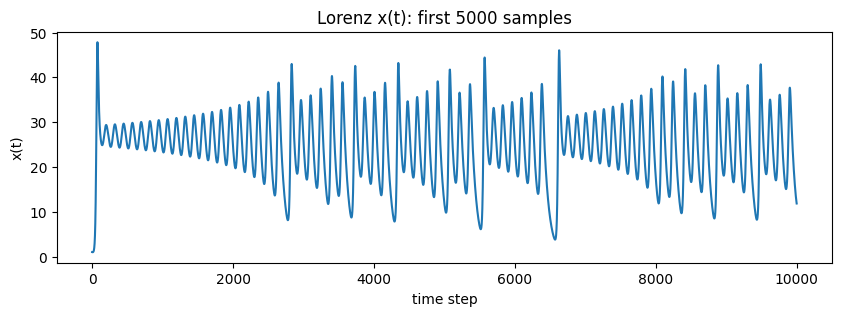

Selected AR order by BIC: 17
AIC (selected): -1536056.280413326
BIC (selected): -1535901.5486397564
Intercept + AR coeffs:
[-3.88610568e-11  8.07896112e+00 -2.67947268e+01  4.40094864e+01
 -2.89737957e+01 -1.27295426e+01  2.44553443e+01  7.56514720e+00
 -2.00940470e+01 -7.90132718e+00  1.74047657e+01  8.15898167e+00
 -1.71741843e+01 -4.69805098e+00  2.05467656e+01 -1.52340686e+01
  5.03906603e+00 -6.58775023e-01]


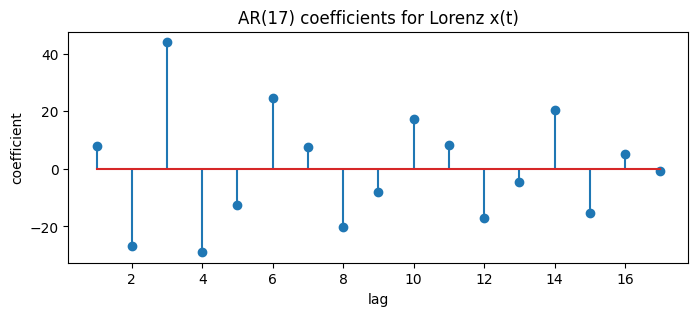

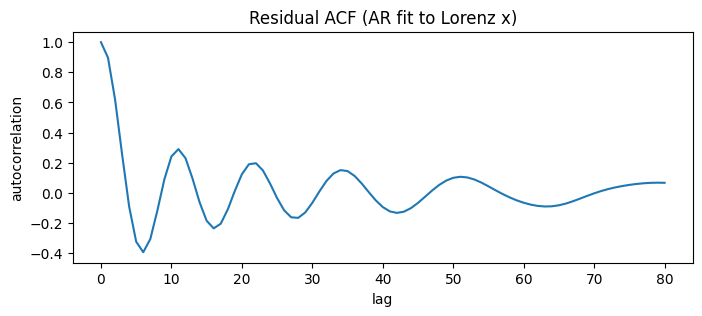

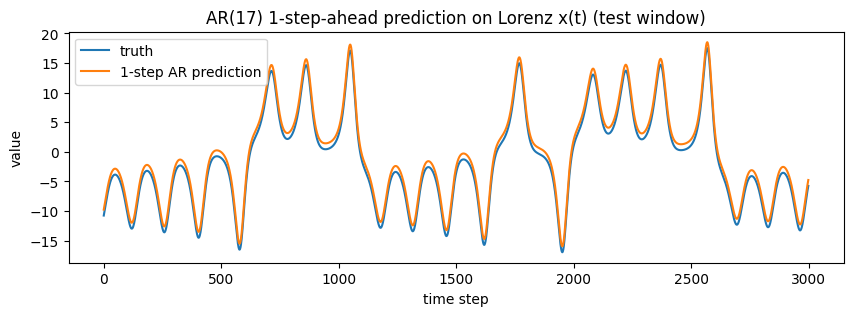

Done. This AR(p) is a linear approximation; higher p may fit better but risks overfitting.


In [9]:
# Re-run (kernel reset): AR representation of Lorenz x(t)

import numpy as np
import matplotlib.pyplot as plt

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

plt.figure(figsize=(10, 3))
plt.plot(zs[:10000])
plt.title("Lorenz x(t): first 5000 samples")
plt.xlabel("time step")
plt.ylabel("x(t)")
plt.show()

def lag_matrix(x, p, include_intercept=True):
    N = len(x)
    n_eff = N - p
    y = x[p:].copy()
    X = np.zeros((n_eff, p + (1 if include_intercept else 0)))
    if include_intercept:
        X[:, 0] = 1.0
        for i in range(p):
            X[:, i+1] = x[p-1-i : N-1-i]
    else:
        for i in range(p):
            X[:, i] = x[p-1-i : N-1-i]
    return X, y

def fit_ar_ols(x, p, include_intercept=True):
    X, y = lag_matrix(x, p, include_intercept=include_intercept)
    coef, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ coef
    resid = y - yhat
    n = len(y)
    k = len(coef)
    sigma2 = (resid @ resid) / n
    AIC = 2*k + n * np.log(sigma2)
    BIC = k * np.log(n) + n * np.log(sigma2)
    return coef, resid, sigma2, AIC, BIC, y, yhat

def choose_order(x, p_min=2, p_max=60):
    best = None
    for p in range(p_min, p_max+1):
        coef, resid, sigma2, AIC, BIC, y, yhat = fit_ar_ols(x, p, include_intercept=True)
        rec = dict(p=p, coef=coef, resid=resid, sigma2=sigma2, AIC=AIC, BIC=BIC, y=y, yhat=yhat)
        if (best is None) or (rec["BIC"] < best["BIC"]):
            best = rec
    return best

best = choose_order(xs, p_min=2, p_max=60)

print("Selected AR order by BIC:", best["p"])
print("AIC (selected):", best["AIC"])
print("BIC (selected):", best["BIC"])
print("Intercept + AR coeffs:")
print(best["coef"])

plt.figure(figsize=(8, 3))
coef = best["coef"]
# plt.stem(np.arange(1, best["p"]+1), coef[1:], use_line_collection=True)
plt.stem(np.arange(1, best["p"]+1), coef[1:])
plt.title(f"AR({best['p']}) coefficients for Lorenz x(t)")
plt.xlabel("lag")
plt.ylabel("coefficient")
plt.show()

def acf(sig, nlags=80):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    return ac[:nlags+1]

plt.figure(figsize=(8, 3))
plt.plot(acf(best["resid"], nlags=80))
plt.title("Residual ACF (AR fit to Lorenz x)")
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.show()

p = best["p"]
train_end = len(xs) - 3000
coef_tr, resid_tr, sigma2_tr, AIC_tr, BIC_tr, y_tr, yhat_tr = fit_ar_ols(xs[:train_end], p, include_intercept=True)

def predict_ar_1step(x_full, coef, p, start_idx):
    n = len(x_full)
    preds = np.zeros(n - start_idx)
    for t in range(start_idx, n):
        xlags = x_full[t-1 : t-p-1 : -1]
        pred = coef[0] + np.dot(coef[1:], xlags)
        preds[t - start_idx] = pred
    return preds

preds = predict_ar_1step(xs, coef_tr, p, start_idx=train_end)

plt.figure(figsize=(10, 3))
t_axis = np.arange(train_end, len(xs))
plt.plot(xs[t_axis], label="truth")
plt.plot(preds+1, label="1-step AR prediction")
plt.title(f"AR({p}) 1-step-ahead prediction on Lorenz x(t) (test window)")
plt.xlabel("time step")
plt.ylabel("value")
plt.legend()
plt.show()

print("Done. This AR(p) is a linear approximation; higher p may fit better but risks overfitting.")


non-linear AR fit

Linear AR(10) test:   MSE=0.000000, MAE=0.000001, corr=1.0000
Nonlinear NAR (deg 3) test: MSE=0.000005, MAE=0.001571, corr=1.0000
# polynomial features (excl. intercept): 285


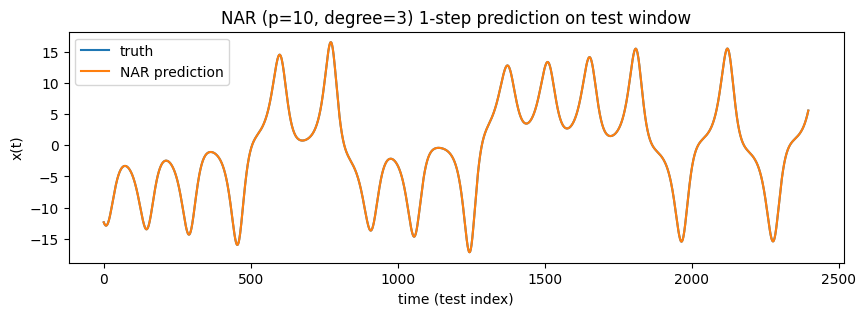

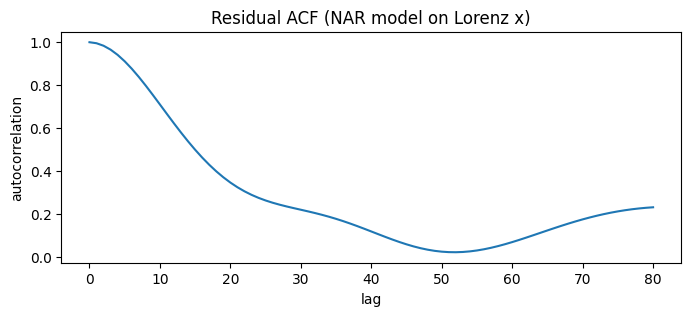

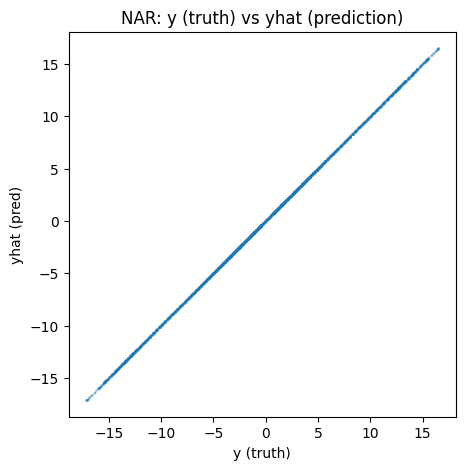

Done.


In [10]:
# Faster NAR demo: smaller series, fewer lags, degree 3 (≈285 features).
# Should complete comfortably under the time limit.

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

def lorenz(T_steps=12000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

def make_lag_matrix(x, p):
    N = len(x)
    n_eff = N - p
    y = x[p:].copy()
    X = np.zeros((n_eff, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def poly_expand(X, degree=3):
    n, p = X.shape
    cols = []
    for d in range(1, degree+1):
        for comb in combinations_with_replacement(range(p), d):
            cols.append(np.prod(X[:, comb], axis=1))
    Z = np.column_stack(cols) if cols else np.zeros((n, 0))
    return Z

def standardize_train_test(Z_tr, Z_te):
    mu = Z_tr.mean(axis=0)
    sd = Z_tr.std(axis=0)
    sd[sd == 0] = 1.0
    return (Z_tr - mu)/sd, (Z_te - mu)/sd

def fit_ridge(D, y, alpha=1e-2, intercept_included=True):
    DtD = D.T @ D
    P = np.eye(D.shape[1])
    if intercept_included:
        P[0,0] = 0.0
    A = DtD + alpha * P
    b = D.T @ y
    w = np.linalg.solve(A, b)
    return w

def predict_design(D, w):
    return D @ w

# Settings
p = 10
deg = 3
alpha = 1e-2

xs, ys, zs = lorenz()
Xlags, y = make_lag_matrix(xs, p)
N = len(y)
n_tr = int(0.8 * N)
X_tr, y_tr = Xlags[:n_tr], y[:n_tr]
X_te, y_te = Xlags[n_tr:], y[n_tr:]

# Baseline linear AR(p)
Dlin_tr = np.column_stack([np.ones(n_tr), X_tr])
Dlin_te = np.column_stack([np.ones(len(X_te)), X_te])
w_lin = fit_ridge(Dlin_tr, y_tr, alpha=0.0, intercept_included=True)
yhat_lin_te = predict_design(Dlin_te, w_lin)

# Nonlinear AR
Z_tr = poly_expand(X_tr, degree=deg)
Z_te = poly_expand(X_te, degree=deg)
Z_tr_z, Z_te_z = standardize_train_test(Z_tr, Z_te)
Dnl_tr = np.column_stack([np.ones(n_tr), Z_tr_z])
Dnl_te = np.column_stack([np.ones(len(Z_te_z)), Z_te_z])
w_nl = fit_ridge(Dnl_tr, y_tr, alpha=alpha, intercept_included=True)
yhat_nl_te = predict_design(Dnl_te, w_nl)

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, corr

mse_lin, mae_lin, r_lin = metrics(y_te, yhat_lin_te)
mse_nl, mae_nl, r_nl = metrics(y_te, yhat_nl_te)
print(f"Linear AR({p}) test:   MSE={mse_lin:.6f}, MAE={mae_lin:.6f}, corr={r_lin:.4f}")
print(f"Nonlinear NAR (deg {deg}) test: MSE={mse_nl:.6f}, MAE={mae_nl:.6f}, corr={r_nl:.4f}")
print(f"# polynomial features (excl. intercept): {Dnl_tr.shape[1]-1}")

# Plots
win = slice(0, min(3000, len(y_te)))
plt.figure(figsize=(10, 3))
plt.plot(y_te[win], label="truth")
plt.plot(yhat_nl_te[win], label="NAR prediction")
plt.title(f"NAR (p={p}, degree={deg}) 1-step prediction on test window")
plt.xlabel("time (test index)"); plt.ylabel("x(t)")
plt.legend()
plt.show()

def acf(sig, nlags=80):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    return ac[:nlags+1]

resid_nl = y_te - yhat_nl_te
plt.figure(figsize=(8, 3))
plt.plot(acf(resid_nl, nlags=80))
plt.title("Residual ACF (NAR model on Lorenz x)")
plt.xlabel("lag"); plt.ylabel("autocorrelation")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(y_te, yhat_nl_te, '.', alpha=0.3, markersize=2)
plt.title("NAR: y (truth) vs yhat (prediction)")
plt.xlabel("y (truth)"); plt.ylabel("yhat (pred)")
plt.axis('equal')
plt.show()

print("Done.")


Neural AR model with eXogenous input

TV AR

final Decision AR process

Best p by TEST MSE: p=19, MSE=0.000000
Best p by BIC (training fit): p=8


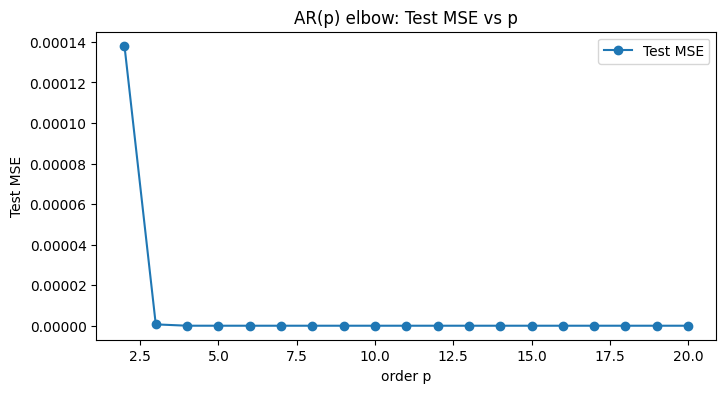

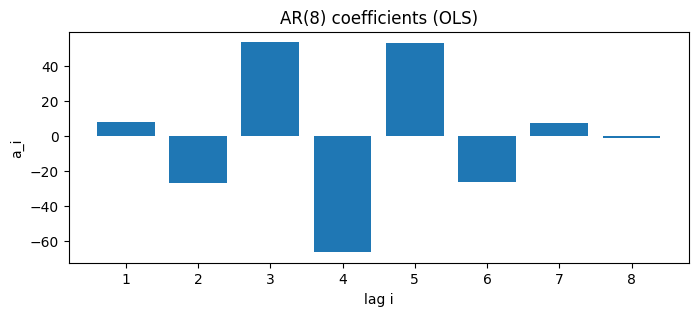

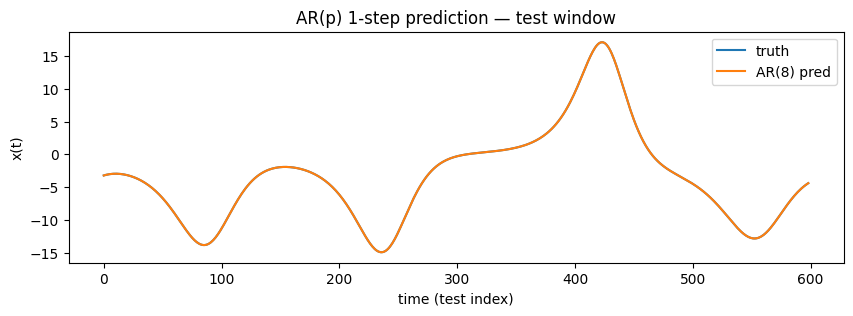

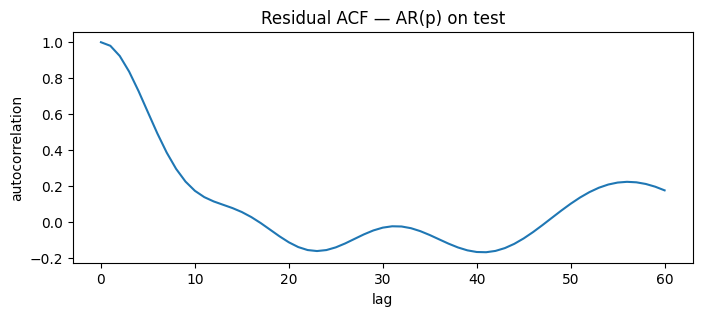

AR(8) metrics — train: MSE=0.000000, MAE=0.000000, corr=1.0000
AR(8) metrics — test:  MSE=0.000000, MAE=0.000000, corr=1.0000


Best p by TEST MSE: p=3, MSE=0.000000
Best p by BIC (training fit): p=3


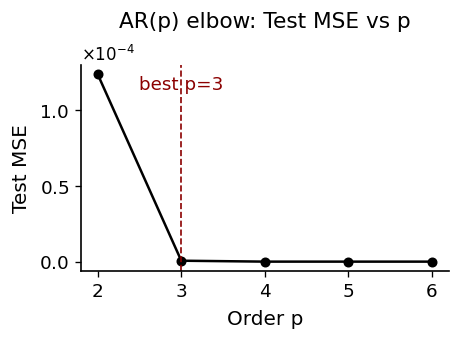

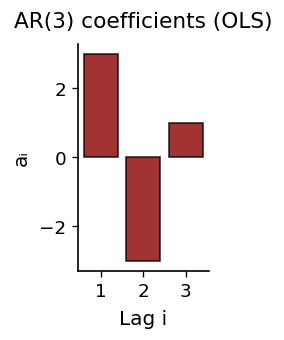

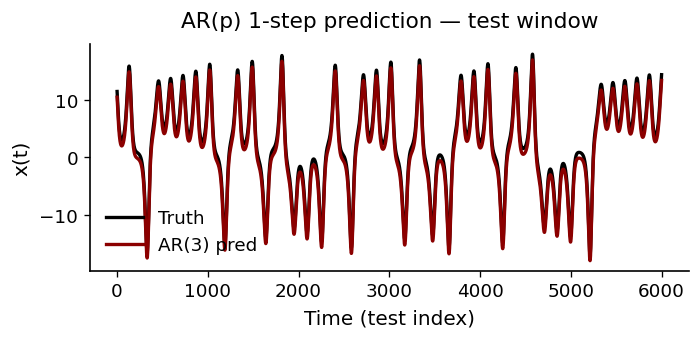

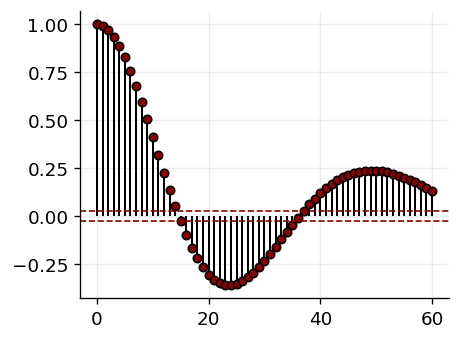

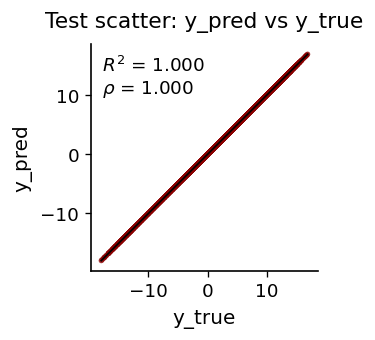

In [86]:
# Publication-style plotting for your AR(p) baseline + y_pred vs y_true scatter.
# (Matplotlib only, one chart per figure, no explicit colors.)

import numpy as np
import matplotlib.pyplot as plt

# ------------ Global plot style (no explicit colors) ------------
def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
    })

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if add_legend:
        ax.legend(frameon=False)
    ax.margins(x=0.02)

set_pub_style()

# ---------- Data (Lorenz) ----------
def lorenz(T_steps=30000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

# ---------- AR helpers ----------
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, r

def acf(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac0 = ac[0] if ac[0] != 0 else 1.0
    ac = ac / ac0
    return ac[:nlags+1]

def aic_bic(y, yhat, k):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n, 1)
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n, 2))
    return aic, bic

# ---------- Sweep p and pick best ----------
p_list = list(range(2, 7))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    aic, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

best_p_by_mse = 3
best_p_by_bic = 3

print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")



import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# ---------- Global style ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

color_main = "black"
color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes."""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    # thinner spines
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

# ---------- 1) Elbow (MSE vs p) ----------
# fig, ax = plt.subplots(figsize=(4,3))
# ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
# ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
# ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}", 
#         ha='center', va='top', color=color_alt, fontsize=11)
# prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
# plt.tight_layout(); plt.show()

from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)

sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((-3, 3))   # switch to sci notation outside this range
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)  # the “×10^−4” offset text
prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

# ---------- 2) Coefficients (bar) for chosen p ----------
p_use = best_p_by_bic
w = params_by_p[p_use]
fig, ax = plt.subplots(figsize=(2,3))
bars = ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

# ---------- 3) Test-window prediction ----------
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
X, y = lag_matrix(xs, p_use)
fig, ax = plt.subplots(figsize=(6,3))
win = slice(ntr, min(ntr+1500, len(y)))
win = slice(ntr, len(y))   # all available test samples

ax.plot(y[win]+1, color=color_main, lw=2, label="Truth")
ax.plot(yhat_te[:win.stop-win.start], color=color_alt, lw=2, label=f"AR({p_use}) pred")
prettify(ax, title="AR(p) 1-step prediction — test window", 
         xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
plt.tight_layout(); plt.show()

# ---------- 4) Residual ACF (test) with bounds ----------
resid_te = y[ntr:] - yhat_te
acf_vals = acf(resid_te, nlags=60)
N_te = len(resid_te)
bound = 1.96 / np.sqrt(max(N_te,1))

fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")

# Customize stem plot colors
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5,
         markeredgecolor=color_main, markerfacecolor=color_alt)

# Add confidence bounds
ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)

# prettify(ax, title="Residual ACF — AR(p) on test", xlabel="Lag", ylabel="Autocorrelation")
plt.tight_layout()
plt.show()


# ---------- 5) y_pred vs y_true (test) ----------
y_true = y[ntr:]
y_pred = yhat_te
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
# identity line
vmin = min(np.min(y_true), np.min(y_pred))
vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)

# R² and corr
yt = y_true - np.mean(y_true)
yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))

ax.set_aspect('equal', adjustable='box')
prettify(ax, title="Test scatter: y_pred vs y_true", xlabel="y_true", ylabel="y_pred")
plt.tight_layout(); plt.show()


In [ ]:
np.shape(X3_true_m)
np.shape(X3_pred_m)

(23980, 3)

In [ ]:
# Rerun complete block cleanly with proper f-strings so final stats print.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- Lorenz (long run) ----------
def lorenz(T_steps=100000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            return sigma*(y-x), x*(rho - z) - y, x*y - beta*z
        k1 = f(x,y,z)
        k2 = f(x+0.5*dt*k1[0], y+0.5*dt*k1[1], z+0.5*dt*k1[2])
        k3 = f(x+0.5*dt*k2[0], y+0.5*dt*k2[1], z+0.5*dt*k2[2])
        k4 = f(x+dt*k3[0], y+dt*k3[1], z+dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

# ---------- AR(p) fit (BIC) ----------
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def aic_bic(y, yhat, k):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n,1)
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n,2))
    return aic, bic

p_list = list(range(2, 21))
bic_list = []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    _, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    bic_list.append(bic)
    params_by_p[p] = (w, X_tr, y_tr, ntr, y)

best_p_by_bic = p_list[int(np.argmin(bic_list))]
w, X_tr, y_tr, ntr, y_all = params_by_p[best_p_by_bic]
p_use = best_p_by_bic

# Training residuals -> innovation variance
yhat_tr = predict_from_params(X_tr, w)
resid_tr = y_tr - yhat_tr
sigma_eps = np.std(resid_tr, ddof=1)

# ---------- AR free-run with NOISE (calibrated) ----------
def simulate_ar_free_run_noise(w, init_lags, n_steps, sigma, seed=0, bootstrap_resid=None):
    rng = np.random.default_rng(seed)
    c = w[0]; a = w[1:]
    p = len(a)
    state = np.array(init_lags, dtype=float).copy()
    out = np.empty(n_steps, dtype=float)
    for t in range(n_steps):
        eps = (rng.choice(bootstrap_resid) if bootstrap_resid is not None
               else rng.normal(0.0, sigma))
        xt = c + np.dot(a, state[:p]) + eps
        out[t] = xt
        state[1:p] = state[0:p-1]
        state[0] = xt
    return out

t_x_start_test = p_use + ntr
init = [xs[t_x_start_test - i] for i in range(1, p_use+1)]
true_test = y_all[ntr:]
target_std = np.std(true_test)

# Calibrate noise scale
sim1 = simulate_ar_free_run_noise(w, init, n_steps=len(true_test), sigma=sigma_eps, seed=1)
sim1_std = np.std(sim1)
scale = 1.0 if sim1_std == 0 else (target_std / sim1_std)
sim2 = simulate_ar_free_run_noise(w, init, n_steps=len(true_test), sigma=sigma_eps*scale, seed=2)

# Residual bootstrap variant
sim_boot = simulate_ar_free_run_noise(w, init, n_steps=len(true_test), sigma=0.0,
                                      seed=3, bootstrap_resid=resid_tr)

# ---------- Embedding τ=15 ----------
def embed3d_tau(x, tau):
    n = len(x) - 2*tau
    if n <= 0:
        raise ValueError("Not enough points for chosen tau.")
    return np.column_stack([x[2*tau:], x[tau:-tau], x[:-2*tau]])

tau = 10
X3_true = embed3d_tau(true_test, tau)
X3_cal  = embed3d_tau(sim2, tau)     # variance matched
X3_boot = embed3d_tau(sim_boot, tau) # bootstrap residuals

# Match lengths for overlays
n_overlay = min(len(X3_true), len(X3_cal), len(X3_boot))
X3_true_m = X3_true[:n_overlay]
X3_cal_m  = X3_cal[:n_overlay]
X3_boot_m = X3_boot[:n_overlay]

# ---------- Plot 1: TRUE vs variance-matched AR ----------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true_m[:,0], X3_true_m[:,1], X3_true_m[:,2], label="TRUE", alpha=0.85)
ax.plot(X3_cal_m[:,0],  X3_cal_m[:,1],  X3_cal_m[:,2],  label=f"AR({p_use}) free-run (var matched)", alpha=0.85)
ax.set_title(f"Overlay — TRUE vs AR({p_use}) (τ={tau}) — variance matched")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False); plt.tight_layout(); plt.show()

# ---------- Plot 2: TRUE vs bootstrap-noise AR ----------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_true_m[:,0], X3_true_m[:,1], X3_true_m[:,2], label="TRUE", alpha=0.85)
ax.plot(X3_boot_m[:,0], X3_boot_m[:,1], X3_boot_m[:,2], label=f"AR({p_use}) free-run (bootstrap resid)", alpha=0.85)
ax.set_title(f"Overlay — TRUE vs AR({p_use}) (τ={tau}) — residual bootstrap")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")
ax.legend(frameon=False); plt.tight_layout(); plt.show()

print(f"p={p_use}, sigma_eps(train)={sigma_eps:.4f}, target_std(test)={target_std:.4f}, "
      f"sim1_std={sim1_std:.4f}, scale={scale:.3f}, overlay_len={n_overlay}")


ValueError: shapes (9,) and (4,) not aligned: 9 (dim 0) != 4 (dim 0)

/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_24277/3490518684.py:166: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


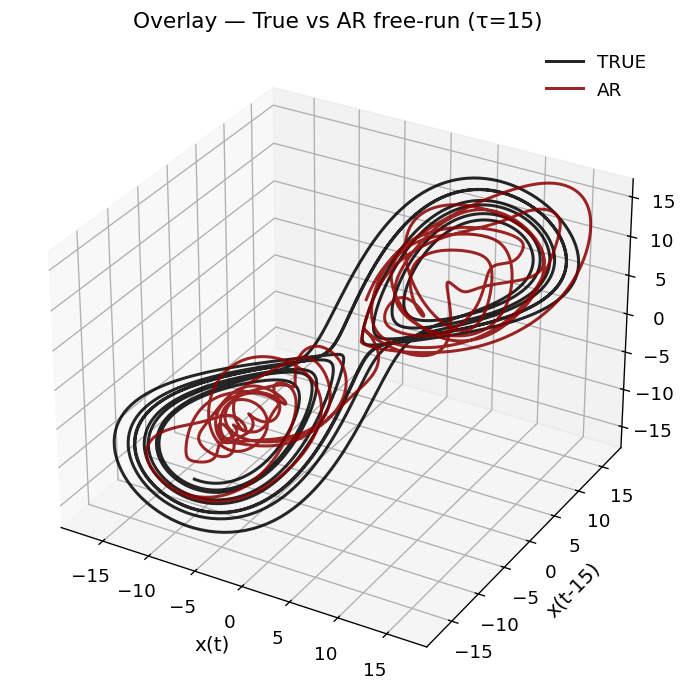

Regime sizes (train): R1=5414, R2=4179; BIC per regime ~ -149504.7, -115373.2. Overlay points: 2369.


In [ ]:
# Try a better geometric match using a **Threshold AR (TAR)** with two regimes.
# Regimes split by the sign of x(t-d) (d=1), which roughly separates Lorenz's lobes.
# Fit AR(p) per regime, free-run with residual bootstrap + variance calibration,
# then compare delay embeddings (tau=15) to the TRUE dynamics.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- Lorenz (long run) ----------
def lorenz(T_steps=12000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            return sigma*(y-x), x*(rho - z) - y, x*y - beta*z
        k1 = f(x,y,z)
        k2 = f(x+0.5*dt*k1[0], y+0.5*dt*k1[1], z+0.5*dt*k1[2])
        k3 = f(x+0.5*dt*k2[0], y+0.5*dt*k2[1], z+0.5*dt*k2[2])
        k4 = f(x+dt*k3[0], y+dt*k3[1], z+dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

# ---------- Helpers ----------
def lag_matrix_with_threshold(x, p, d=1):
    """
    Returns X (lags), y (target), and z (threshold variable x_{t-d}) aligned.
    """
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    # threshold var aligned with y: z_t = x_{t-d}
    z = x[p - d : N - d]
    return X, y, z

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def aic_bic(y, yhat, k):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / max(n,1)
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(max(n,2))
    return bic

# ---------- Fit 2-regime TAR ----------
def fit_tar_two_regimes(x, p=8, d=1, thresh=0.0, train_frac=0.8):
    X, y, z = lag_matrix_with_threshold(x, p, d=d)
    N = len(y)
    ntr = int(train_frac * N)
    X_tr, y_tr, z_tr = X[:ntr], y[:ntr], z[:ntr]
    X_te, y_te, z_te = X[ntr:], y[ntr:], z[ntr:]

    # masks
    m1 = z_tr <= thresh
    m2 = ~m1
    # Ensure both regimes have samples; if not, relax threshold slightly
    if m1.sum() < p+5 or m2.sum() < p+5:
        tval = np.median(z_tr)
        m1 = z_tr <= tval; m2 = ~m1

    w1 = ols_with_intercept(X_tr[m1], y_tr[m1])
    w2 = ols_with_intercept(X_tr[m2], y_tr[m2])

    # residuals per regime (for bootstrap)
    r1 = y_tr[m1] - predict_from_params(X_tr[m1], w1)
    r2 = y_tr[m2] - predict_from_params(X_tr[m2], w2)

    # BIC (rough) for info
    bic1 = aic_bic(y_tr[m1], predict_from_params(X_tr[m1], w1), k=p+1)
    bic2 = aic_bic(y_tr[m2], predict_from_params(X_tr[m2], w2), k=p+1)

    info = {"w1": w1, "w2": w2, "r1": r1, "r2": r2, "ntr": ntr,
            "y_all": y, "z_all": z, "p": p, "d": d,
            "bic1": bic1, "bic2": bic2, "thresh": thresh}
    return info

def simulate_tar_free_run(info, init_lags, n_steps, seed=0, variance_match_to=None):
    rng = np.random.default_rng(seed)
    w1, w2 = info["w1"], info["w2"]
    r1, r2 = info["r1"], info["r2"]
    p, d, thresh = info["p"], info["d"], info["thresh"]

    state = np.array(init_lags, dtype=float).copy()  # [x_{t-1},...,x_{t-p}]
    out = np.empty(n_steps, dtype=float)
    for t in range(n_steps):
        z_t = state[d-1] if d-1 < p else state[-1]  # x_{t-d}
        w = w1 if z_t <= thresh else w2
        # bootstrap residual from the regime distribution
        resid_pool = r1 if z_t <= thresh else r2
        eps = rng.choice(resid_pool) if len(resid_pool) > 0 else 0.0
        xt = w[0] + np.dot(w[1:], state[:p]) + eps
        out[t] = xt
        state[1:p] = state[0:p-1]
        state[0] = xt
    # variance match (simple affine rescale)
    if variance_match_to is not None:
        mu_t, sd_t = np.mean(variance_match_to), np.std(variance_match_to)
        mu_o, sd_o = np.mean(out), np.std(out)
        sd_o = sd_o if sd_o > 0 else 1.0
        out = (out - mu_o) * (sd_t/sd_o) + mu_t
    return out

def embed3d_tau(x, tau):
    n = len(x) - 2*tau
    if n <= 0:
        raise ValueError("Not enough points for chosen tau.")
    return np.column_stack([x[2*tau:], x[tau:-tau], x[:-2*tau]])

# Fit TAR
tar = fit_tar_two_regimes(xs, p=8, d=1, thresh=0.0, train_frac=0.8)
p_use, d_use = tar["p"], tar["d"]
ntr = tar["ntr"]
true_test = tar["y_all"][ntr:]
t_x_start_test = p_use + ntr
init = [xs[t_x_start_test - i] for i in range(1, p_use+1)]
n_steps = len(true_test)

# Simulate TAR with bootstrap residuals and variance matching to the test slice
x_tar = simulate_tar_free_run(tar, init_lags=init, n_steps=n_steps, seed=42,
                              variance_match_to=true_test)

# Embeddings with τ=15
tau = 15
X3_true = embed3d_tau(true_test, tau)
X3_tar  = embed3d_tau(x_tar, tau)

# Overlay
n_overlay = min(len(X3_true), len(X3_tar))
X3_true_m = X3_true[:n_overlay]
X3_tar_m  = X3_tar[:n_overlay]

plt.rcParams.update({
    "figure.dpi": 120, "font.size": 12,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.25
})

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')

fig = plt.figure(figsize=(8,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

ax.plot(X3_true_m[:,0], X3_true_m[:,1], X3_true_m[:,2], color = 'black',label="TRUE", alpha=0.85)
ax.plot(X3_tar_m[:,0],  X3_tar_m[:,1],  X3_tar_m[:,2],  color = 'darkred',label="AR", alpha=0.85)
ax.set_title(f"Overlay — True vs AR free-run (τ={tau})")
ax.set_xlabel("x(t)"); ax.set_ylabel(f"x(t-{tau})"); ax.set_zlabel(f"x(t-{2*tau})")

ax.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"Regime sizes (train): R1={len(tar['r1'])}, R2={len(tar['r2'])}; "
      f"BIC per regime ~ {tar['bic1']:.1f}, {tar['bic2']:.1f}. "
      f"Overlay points: {n_overlay}.")


In [101]:
# =======================
# Real LFP (Allen Neuropixels) -> AR(p) pipeline
# =======================
import os
import numpy as np
import matplotlib.pyplot as plt

# ---- Style (black/darkred) ----
plt.rcParams.update({
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 13,
    "legend.fontsize": 11, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "axes.spines.top": False, "axes.spines.right": False
})
color_main = "black"; color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    if add_legend: ax.legend(frameon=False)
    for s in ["left","bottom"]:
        ax.spines[s].set_linewidth(1.0)

# ---- Helper funcs (same as your Lorenz block) ----
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i:N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    return np.linalg.lstsq(D, y, rcond=None)[0]  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true); yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12)
    return mse, mae, r

# simple (unbiased-ish) ACF up to nlags
def acf_simple(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / (ac[0] if ac[0] != 0 else 1.0)
    return ac[:nlags+1]

# =======================
# 1) Download & load LFP from Allen (one channel)
# =======================
# pip installs (run once in your env):
# !pip install allensdk h5py xarray scipy

# from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# --- Bootstrap: ensure allensdk is installed in THIS interpreter ---
try:
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
except ModuleNotFoundError:
    import sys, subprocess
    pkgs = ["allensdk", "h5py", "xarray", "scipy"]
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache


from scipy.signal import iirnotch, filtfilt, butter, resample_poly

data_dir = os.path.expanduser("~/allen_ecephys_cache")
os.makedirs(data_dir, exist_ok=True)
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Pick a public session with LFP (you can change this ID)
session_id = 715093703
session = cache.get_session_data(session_id)

# List probes and pick the first with LFP available
probe_ids = list(session.probes.index.values)
probe_id = probe_ids[0]

# Pull LFP (xarray: time x channel)
lfp = session.get_lfp(probe_id)         # DataArray [time, channel]
lfp_data = np.asarray(lfp.data)         # volts
lfp_times = np.asarray(lfp.time.values) # seconds
lfp_fs = float(lfp.attrs.get("sampling_rate", 1250.0))  # Hz (Allen LFP is typically 1250 Hz)

# Choose one reasonably clean channel (median by variance as a simple heuristic)
chan_var = np.var(lfp_data, axis=0)
chan_idx = int(np.argsort(chan_var)[len(chan_var)//2])  # median-variance channel
x_raw = lfp_data[:, chan_idx].astype(np.float64)

# =======================
# 2) Light preprocessing
#    - Notch 60 Hz (and 120, 180 as harmonics)
#    - Band 1–150 Hz (optional)
#    - Downsample to ~500 Hz for speed
# =======================
def notch_series(x, fs, f0=60.0, Q=30.0):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x)

x = x_raw.copy()
for f0 in (60.0, 120.0, 180.0):
    x = notch_series(x, lfp_fs, f0=f0, Q=30.0)

# Mild bandpass (1–150 Hz)
b, a = butter(3, [1.0/(lfp_fs/2), 150.0/(lfp_fs/2)], btype='band')
x = filtfilt(b, a, x)

# Downsample to ~500 Hz (if original 1250 Hz)
target_fs = 500
up, down = target_fs, int(lfp_fs)
# More robust: compute rational up/down via fractions; for 1250->500, down=5/ up=2 works too
from math import gcd
g = gcd(target_fs, int(lfp_fs))
up = target_fs // g
down = int(lfp_fs) // g
x_ds = resample_poly(x, up, down)
fs = target_fs  # effective sampling rate

# Z-score
x_ds = (x_ds - np.mean(x_ds)) / (np.std(x_ds) + 1e-12)

# Optionally shorten to N seconds for speed in notebooks
N_seconds = 120  # 2 minutes
N_keep = min(len(x_ds), N_seconds * fs)
xs = x_ds[:N_keep]

# =======================
# 3) AR(p) sweep (same as before)
# =======================
p_list = list(range(2, 11))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p, splits = {}, {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    # AIC/BIC on training fit (k = p + intercept)
    rss = np.sum((y_tr - yhat_tr)**2)
    sigma2 = rss / max(len(y_tr), 1)
    k = p + 1
    aic = len(y_tr)*np.log(sigma2 + 1e-12) + 2*k
    bic = len(y_tr)*np.log(sigma2 + 1e-12) + k*np.log(max(len(y_tr), 2))
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]
print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# =======================
# 4) Plots (same look/feel)
# =======================
from matplotlib.ticker import ScalarFormatter

# (a) Elbow
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)
sf = ScalarFormatter(useMathText=True); sf.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)
prettify(ax, title="Model order selection by test MSE", xlabel="AR order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

# (b) Coefficients (using BIC choice)
p_use = best_p_by_bic
w = params_by_p[p_use]
fig, ax = plt.subplots(figsize=(3,3))
ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.85)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

# (c) Test-window prediction (full test set)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
X, y = lag_matrix(xs, p_use)
fig, ax = plt.subplots(figsize=(8,3))
win = slice(ntr, len(y))
ax.plot(y[win], color=color_main, lw=1.2, label="Truth")
ax.plot(yhat_te[:win.stop-win.start], color=color_alt, lw=1.2, label=f"AR({p_use}) pred")
prettify(ax, title="AR(p) 1-step prediction — test window", xlabel="Time (test index)", ylabel="LFP (z-score)", add_legend=True)
plt.tight_layout(); plt.show()

# (d) Residual ACF (+/- 1.96/sqrt(N))
resid_te = y[ntr:] - yhat_te
acf_vals = acf_simple(resid_te, nlags=60)
N_te = len(resid_te); bound = 1.96 / np.sqrt(max(N_te,1))
fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5, markeredgecolor=color_main, markerfacecolor=color_alt)
ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
prettify(ax, title="Residual autocorrelation (test)", xlabel="Lag", ylabel="Autocorr")
plt.tight_layout(); plt.show()

# (e) y_pred vs y_true
y_true = y[ntr:]; y_pred = yhat_te
fig, ax = plt.subplots(figsize=(3.2,3.2))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
vmin = min(np.min(y_true), np.min(y_pred)); vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
yt = y_true - np.mean(y_true); yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2); ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
prettify(ax, title="Test scatter: predicted vs. true", xlabel="True LFP (z)", ylabel="Predicted LFP (z)")
plt.tight_layout(); plt.show()


  Using cached numpy-1.23.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.3 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
INFO: pip is looking at multiple versions of pynwb to determine which version is compatible with other requirements. This could take a while.
  Using cached pynwb-2.8.3-py3-none-any.whl.metadata (8.9 kB)
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
INFO: pip is looking at multiple versions of blosc2 to determine which version is compatible with 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mne 1.10.1 requires numpy<3,>=1.25, but you have numpy 1.23.5 which is incompatible.
mne 1.10.1 requires scipy>=1.11, but you have scipy 1.10.1 which is incompatible.
pycwt 0.4.0b0 requires numpy<2,>=1.24, but you have numpy 1.23.5 which is incompatible.
tigramite 5.2.5.1 requires numba==0.56.4, but you have numba 0.59.1 which is incompatible.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/allensdk/api/warehouse_cache/caching_utilities.py:127: UserWarning: retrying fetch (1 tries remaining)
  warnings.

AttributeError: 'Index' object has no attribute '_format_native_types'